Epoch 1: Loss=0.5594, Test Acc=0.9265
Epoch 2: Loss=0.2206, Test Acc=0.9358
Epoch 3: Loss=0.1591, Test Acc=0.9596
Epoch 4: Loss=0.1241, Test Acc=0.9611
Epoch 5: Loss=0.1012, Test Acc=0.9637
Epoch 6: Loss=0.0884, Test Acc=0.9720
Epoch 7: Loss=0.0755, Test Acc=0.9718
Epoch 8: Loss=0.0655, Test Acc=0.9696
Epoch 9: Loss=0.0593, Test Acc=0.9722
Epoch 10: Loss=0.0523, Test Acc=0.9682
Epoch 1: Loss=0.2262, Test Acc=0.9695
Epoch 2: Loss=0.0862, Test Acc=0.9731
Epoch 3: Loss=0.0573, Test Acc=0.9774
Epoch 4: Loss=0.0405, Test Acc=0.9803
Epoch 5: Loss=0.0306, Test Acc=0.9804
Epoch 6: Loss=0.0221, Test Acc=0.9802
Epoch 7: Loss=0.0175, Test Acc=0.9820
Epoch 8: Loss=0.0147, Test Acc=0.9824
Epoch 9: Loss=0.0115, Test Acc=0.9825
Epoch 10: Loss=0.0089, Test Acc=0.9829


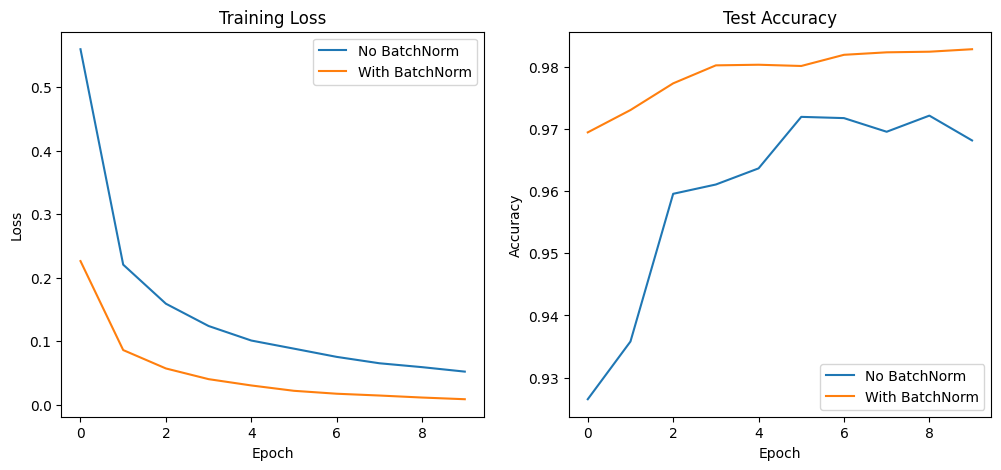

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# -------------------------------
# 1. 데이터셋 불러오기 (MNIST)
# -------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# -------------------------------
# 2. 모델 정의 (배치 정규화 유무 비교)
# -------------------------------
class MLP(nn.Module):
    def __init__(self, use_bn=False):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(784, 256))
        if use_bn:
            layers.append(nn.BatchNorm1d(256))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(256, 128))
        if use_bn:
            layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(128, 10))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # (batch, 784)
        return self.net(x)

# 모델 두 개 생성
model_no_bn = MLP(use_bn=False)
model_bn = MLP(use_bn=True)

# -------------------------------
# 3. 학습 함수 정의
# -------------------------------
def train(model, optimizer, epochs=5):
    train_losses = []
    test_accs = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = F.cross_entropy(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 테스트 정확도
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                output = model(x)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = correct / total
        test_accs.append(acc)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Test Acc={acc:.4f}")
    return train_losses, test_accs

# -------------------------------
# 4. 학습 실행
# -------------------------------
opt_no_bn = optim.SGD(model_no_bn.parameters(), lr=0.1)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.1)

loss_no_bn, acc_no_bn = train(model_no_bn, opt_no_bn, epochs=10)
loss_bn, acc_bn = train(model_bn, opt_bn, epochs=10)

# -------------------------------
# 5. 결과 시각화
# -------------------------------
plt.figure(figsize=(12,5))

# 손실 비교
plt.subplot(1,2,1)
plt.plot(loss_no_bn, label="No BatchNorm")
plt.plot(loss_bn, label="With BatchNorm")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 정확도 비교
plt.subplot(1,2,2)
plt.plot(acc_no_bn, label="No BatchNorm")
plt.plot(acc_bn, label="With BatchNorm")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
